## Setup

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# Load environment variables
load_dotenv()

# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## Define tools

In [37]:
# pip install composio-langchain

In [3]:
pip install -U duckduckgo-search

Note: you may need to restart the kernel to use updated packages.


In [18]:
from typing import Annotated
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from composio_langchain import ComposioToolSet, App

In [19]:
# composio_toolset = ComposioToolSet(api_key="1akfta3ryezvzsmbu02fna")


In [20]:
duckduckgo_tool = DuckDuckGoSearchResults()


In [21]:
repl = PythonREPL()


In [22]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
<>:11: SyntaxWarning: invalid escape sequence '\`'
C:\Users\DNSOFT\AppData\Local\Temp\ipykernel_17732\1318451239.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\DNSOFT\AppData\Local\Temp\ipykernel_17732\1318451239.py:11: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


## Create graph

### Define Agent Nodes

Here we define nodes

In [23]:
def make_system_prompt(suffix: str) -> str:
    return (
        """
        ##Instruction
        You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.
        ##Role
        """
        f"\n{suffix}"
    )

In [24]:
make_system_prompt("dd")

"\n        ##Instruction\n        You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\n        ##Role\n        \ndd"

In [37]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatOpenAI(model="gpt-4o-mini")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[duckduckgo_tool],
    state_modifier=make_system_prompt(
        "You are a senior researcher with twenty years of experience. You only do research. You are working with a chart generator colleague. You should provide accurate data for use, and source code shouldn't be the final answer"
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You are an expert data analyst with twenty years of experience whose main expertise is visualizing data. Here you only do make charts in python. You are working with a researcher colleague.Run the python code to display the chart."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph

In [38]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

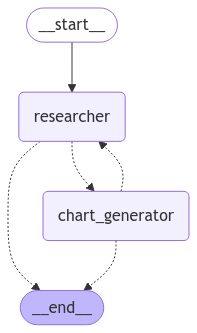

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Invoke

c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\DNSOFT\test_notebooks_\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: 'api' backend is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(
c:\Users\D

{'researcher': {'messages': [HumanMessage(content="First, get the Republic of Korea's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='ea1f93ec-8ddc-462d-9f00-933d8c24219e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gviyf9tOSSxE7XbeJCacL7cQ', 'function': {'arguments': '{"query":"Republic of Korea GDP data 2018 2019 2020 2021 2022 2023"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 242, 'total_tokens': 283, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d4b736c1-23eb-49f1

[2024-12-30 10:36:33,572][WARNING] Python REPL can execute arbitrary code. Use with caution.


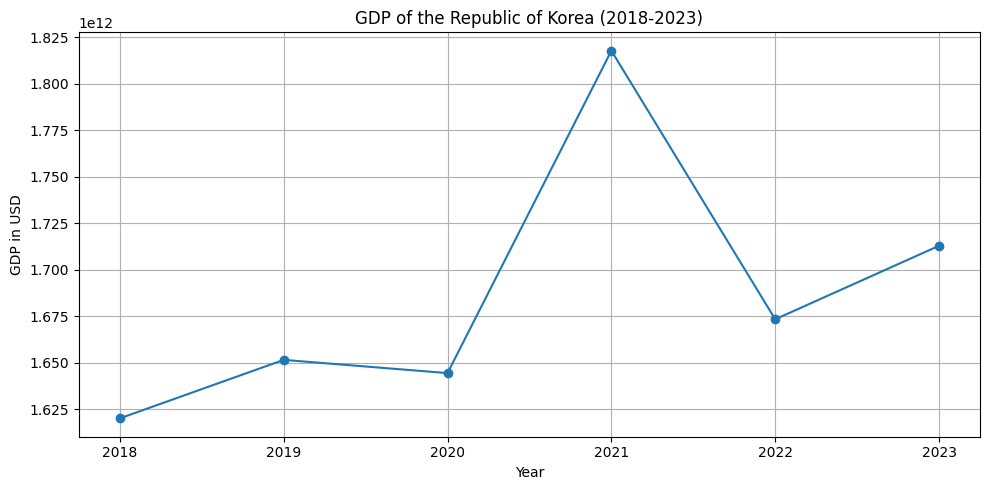

{'chart_generator': {'messages': [HumanMessage(content="First, get the Republic of Korea's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='ea1f93ec-8ddc-462d-9f00-933d8c24219e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gviyf9tOSSxE7XbeJCacL7cQ', 'function': {'arguments': '{"query":"Republic of Korea GDP data 2018 2019 2020 2021 2022 2023"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 242, 'total_tokens': 283, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d4b736c1-23eb

: 

In [40]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the Republic of Korea's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")